<a href="https://colab.research.google.com/github/siddup9999/Customer-Lifetime-Value/blob/main/Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/Scanner Data/scanner_data.csv'

In [4]:
# Load the data

df = pd.read_csv(data_path)

In [5]:
df.Date=pd.to_datetime(df.Date)
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13
1,2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46
2,3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35
3,4,2016-02-01,3719,4,0H2,549KK,1.0,5.59
4,5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88


In [6]:
print(f"Number of customers in dataset: {df.Customer_ID.nunique()}")
print(f"Number of SKU Groups in dataset: {df.SKU_Category.nunique()}")
print(f"Date range in dataset: {df.Date.min()} - {df.Date.max()}")

Number of customers in dataset: 22625
Number of SKU Groups in dataset: 187
Date range in dataset: 2016-01-02 00:00:00 - 2016-12-31 00:00:00


In [7]:
df_clean = df[['Date','Customer_ID','Transaction_ID','Quantity','Sales_Amount']]
df_clean.head()

,Date,Customer_ID,Transaction_ID,Quantity,Sales_Amount
0,2016-02-01,2547,1,1.0,3.13
1,2016-02-01,822,2,1.0,5.46
2,2016-02-01,3686,3,1.0,6.35
3,2016-02-01,3719,4,1.0,5.59
4,2016-02-01,9200,5,1.0,6.88


In [8]:
def customer_frequency(data, cut_off, date_column, customer_id_column, value_column, freq='M'):
  # Get data before cut off
  frequency = data[data[date_column] < cut_off].copy()
  frequency.set_index(date_column, inplace=True)
  frequency.index = pd.DatetimeIndex(frequency.index)
  # Group transaction by customer key
  frequency = frequency.groupby([
      customer_id_column,
      pd.Grouper(freq=freq, level=date_column)
  ]).count()
  frequency[value_column] = 1 # Store all disinct transactions
  #Sum distinct transactions
  return frequency.groupby(customer_id_column).sum().reset_index().rename(
      columns={value_column : 'frequency'}
  )

def customer_recency(data, cut_off, date_column, customer_id_column):
  # Get data before cut off
  recency = data[data[date_column] < cut_off].copy()
  recency[date_column] = pd.to_datetime(recency[date_column])
  # Group Customers by latest transaction
  recency = recency.groupby(customer_id_column)[date_column].max()
  return ((pd.to_datetime(cut_off) - recency).dt.days).reset_index().rename(
      columns={date_column : 'recency'}
  )
  
def customer_age(data, cut_off, date_column, customer_id_column):
  age = data[data[date_column] < cut_off]
  first_purchase = age.groupby(customer_id_column)[date_column].min().reset_index()
  # Get number of days between cut off and first transaction
  first_purchase['age'] = (cut_off - first_purchase[date_column]).dt.days
  return first_purchase[[customer_id_column,'age']]

def customer_value(data, cut_off, date_column, customer_id_column, value_column):
  value = data[data[date_column] < cut_off]
  value.set_index(date_column, inplace = True)
  value.index = pd.DatetimeIndex(value.index)
  # Get mean sales amount for each customer
  return value.groupby(customer_id_column)[value_column].mean().reset_index().rename(
      columns={value_column : 'value'}
  )

def customer_rfm(data, cut_off, date_column, customer_id_column, value_column, freq='M'):
  cut_off = pd.to_datetime(cut_off)
  # Compute Recency
  recency = customer_recency(data, cut_off, date_column, customer_id_column)
  # Compute Frequency
  frequency = customer_frequency(data, cut_off, date_column, customer_id_column, value_column, freq=freq)
  # Compute average value
  value = customer_value(data, cut_off, date_column, customer_id_column, value_column)
  # Compute age
  age = customer_age(data, cut_off, date_column, customer_id_column)
  #Merge all columns
  return recency.merge(
      frequency, on= customer_id_column
      ).merge(
          value, on=customer_id_column
          ).merge(age, on=customer_id_column)

In [9]:
cut_off = datetime.date(2016, 6, 1)
data_for_rfm = df_clean[['Date', 'Customer_ID', 'Sales_Amount']]
rfm_df = customer_rfm(data_for_rfm, cut_off, 'Date', 'Customer_ID', 'Sales_Amount', freq='W')

In [10]:
rfm_df

,Customer_ID,recency,frequency,value,age
0,1,131,1,8.145000,131
1,2,69,1,7.770000,69
2,3,121,1,3.640000,121
3,5,4,4,14.672500,100
4,6,62,1,8.516667,62
...,...,...,...,...,...
13662,22611,20,1,8.750000,20
13663,22619,50,1,3.090000,50
13664,22620,142,1,8.600000,142
13665,22624,110,1,9.800000,110


In [11]:
def recursive_rfm(data, date_col, id_col, value_col, freq='M', start_length=30, label_period_days=30):
  dset_list=[]

  # Get start and end dates of dataset
  start_date = data[date_col].min() + pd.Timedelta(start_length, unit = 'D')
  end_date = data[date_col].max() - pd.Timedelta(label_period_days, units='D')
  # Get dates at desired interval
  dates = pd.date_range(start=start_date, end=end_date, freq=freq)
  data[date_col]=pd.to_datetime(data[date_col])

  for cut_off in dates:
    # split
    observed = data[data[date_col] < cut_off]
    future = data[
        (data[date_col] > cut_off) &
        (data[date_col] < cut_off + pd.Timedelta(label_period_days, unit='D'))
    ]

    rfm_columns = [date_col, id_col, value_col]
    print(f"computing rfm features for {cut_off} to {future[date_col].max()}:")
    _observed = observed[rfm_columns]
    # Compute features from observed
    rfm_features = customer_rfm(_observed, cut_off, date_col, id_col, value_col)
    # Compute labels from fuure
    labels = future.groupby(id_col)[value_col].sum()
    # Outer join features with labels to ensure customers not in observed are
    # still recorderd
    dset = rfm_features.merge(labels, on=id_col, how='outer').fillna(0)
    dset_list.append(dset)
  full_dataset = pd.concat(dset_list, axis=0)
  res = full_dataset[full_dataset.recency !=0].dropna(axis=1, how='any')
  return res

In [12]:
rec_df = recursive_rfm(data_for_rfm, 'Date', 'Customer_ID', 'Sales_Amount')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


computing rfm features for 2016-02-29 00:00:00 to 2016-03-29 00:00:00:
computing rfm features for 2016-03-31 00:00:00 to 2016-04-29 00:00:00:
computing rfm features for 2016-04-30 00:00:00 to 2016-05-29 00:00:00:
computing rfm features for 2016-05-31 00:00:00 to 2016-06-29 00:00:00:
computing rfm features for 2016-06-30 00:00:00 to 2016-07-29 00:00:00:
computing rfm features for 2016-07-31 00:00:00 to 2016-08-29 00:00:00:
computing rfm features for 2016-08-31 00:00:00 to 2016-09-29 00:00:00:
computing rfm features for 2016-09-30 00:00:00 to 2016-10-29 00:00:00:
computing rfm features for 2016-10-31 00:00:00 to 2016-11-29 00:00:00:
computing rfm features for 2016-11-30 00:00:00 to 2016-12-29 00:00:00:


In [13]:
rec_df = rec_df.sample(frac=1)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [15]:
X = rec_df[['recency', 'frequency', 'value', 'age']]
y = rec_df[['Sales_Amount']].values.reshape(-1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 42, shuffle=True)

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 50).fit(X_train, y_train)

In [17]:
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = rf.predict(X_train)

In [18]:
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = rf.predict(X_test)


In [19]:
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(predictions.true, predictions.preds) ** 0.5
test_rmse = mean_squared_error(predictions_test.true, predictions_test.preds) **0.5

print(f"Train RMSE : {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE : 10.739094587178217, Test RMSE: 28.133155560592037


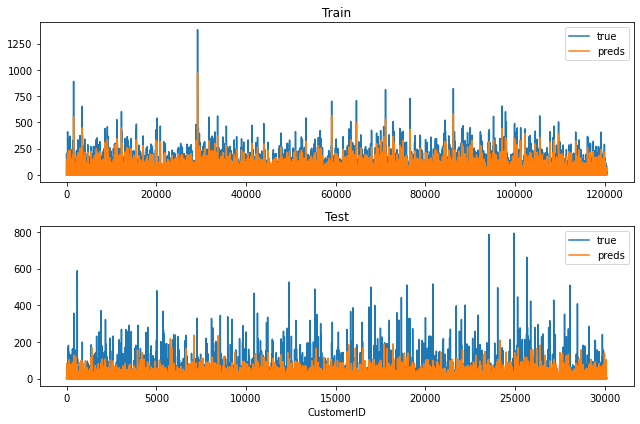

In [20]:
import matplotlib.pyplot as plt

fig, ax  =plt.subplots(2, figsize = (9,6))
predictions.plot(ax=ax[0], title = 'Train')
predictions_test.plot(ax=ax[1], title = 'Test')
plt.xlabel('CustomerID')
plt.tight_layout()
plt.show()

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [22]:
n_features = X.shape[-1]
hidden_sizes = [64, 32, 16, 8]
model = Sequential()
for nhid in hidden_sizes:
  model.add(Dense(nhid, input_dim=n_features, activation ='relu'))
  model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss=tf.keras.metrics.mean_squared_error, optimizer='adam', metrics=['mse'])

In [23]:
X = rec_df[['recency','frequency', 'value', 'age']]
y = rec_df[['Sales_Amount']].values.reshape(-1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=test_size, random_state=42, shuffle = True)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
label_scaler = StandardScaler().fit(y_train.reshape(-1, 1))

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
y_train_norm = label_scaler.transform(y_train.reshape(-1,1))
y_test_norm = label_scaler.transform(y_test.reshape(-1,1))

train_inputs = X_train_norm.copy()
train_labels = y_train_norm.copy()

val_inputs = X_test_norm.copy()
val_labels = y_test_norm.copy()

In [26]:
train_inputs.shape, train_labels.shape, val_inputs.shape, val_labels.shape

((120408, 4), (120408, 1), (30103, 4), (30103, 1))

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [28]:
model.fit(train_inputs, train_labels, batch_size = 128, epochs = 50, verbose = 1)

Epoch 1/50
941/941 [==============================] - 3s 3ms/step - loss: 0.9535 - mse: 0.9535
Epoch 2/50
941/941 [==============================] - 2s 3ms/step - loss: 0.9332 - mse: 0.9332
Epoch 3/50
941/941 [==============================] - 2s 2ms/step - loss: 0.9270 - mse: 0.9270
Epoch 4/50
941/941 [==============================] - 2s 2ms/step - loss: 0.9238 - mse: 0.9238
Epoch 5/50
941/941 [==============================] - 2s 2ms/step - loss: 0.9241 - mse: 0.9241
Epoch 6/50
941/941 [==============================] - 2s 2ms/step - loss: 0.9197 - mse: 0.9197
Epoch 7/50
941/941 [==============================] - 2s 2ms/step - loss: 0.9180 - mse: 0.9180
Epoch 8/50
941/941 [==============================] - 2s 2ms/step - loss: 0.9168 - mse: 0.9168
Epoch 9/50
941/941 [==============================] - 2s 2ms/step - loss: 0.9143 - mse: 0.9143
Epoch 10/50
941/941 [==============================] - 2s 2ms/step - loss: 0.9129 - mse: 0.9129
Epoch 11/50
941/941 [============================